# Using QInfer to estimate the amplitude of Ramsey fringe

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from qinfer.derived_models import BinomialModel
from qinfer.distributions import UniformDistribution, PostselectedDistribution
from qinfer.simple_est import load_data_or_txt, data_to_params, do_update

_twopi = 2 * np.pi

In [55]:
from qinfer.abstract_model import FiniteOutcomeModel


class AmplitudeEstimator(FiniteOutcomeModel):
    r"""
    Describes the free evolution of a single qubit prepared in the
    :math:`\left|+\right\rangle` state under a Hamiltonian :math:`H = \omega \sigma_z / 2`,
    using the interactive QLE model proposed by [WGFC13a]_.

    :param float min_freq: Minimum value for :math:`\omega` to accept as valid.
        This is used for testing techniques that mitigate the effects of
        degenerate models; there is no "good" reason to ever set this other
        than zero, other than to test with an explicitly broken model.
    """

    ## INITIALIZER ##

    def __init__(self, freq):
        super().__init__()
        # self._min_freq = freq
        self._freq = freq

    ## PROPERTIES ##

    @property
    def n_modelparams(self):
        return 2

    @property
    def modelparam_names(self):
        return [
            r'a',
            r'offset'
        ]

    @property
    def expparams_dtype(self):
        return [('t', 'float')]

    @property
    def is_n_outcomes_constant(self):
        """
        Returns ``True`` if and only if the number of outcomes for each
        experiment is independent of the experiment being performed.

        This property is assumed by inference engines to be constant for
        the lifetime of a Model instance.
        """
        return True

    ## METHODS ##

    def are_models_valid(self, modelparams):
        """

        Args:
            modelparams:

        Returns:

        """
        # return np.all(np.ones(modelparams.shape), axis=1)  # np.all(modelparams > self._min_freq, axis=1)
        a = modelparams[:, 0]
        offset = modelparams[:, 1]
        return np.logical_and(-a + offset > 0, a + offset < 1)
#         return np.ones(a.shape)
        
    def n_outcomes(self, expparams):
        """
        Returns an array of dtype ``uint`` describing the number of outcomes
        for each experiment specified by ``expparams``.

        :param numpy.ndarray expparams: Array of experimental parameters. This
            array must be of dtype agreeing with the ``expparams_dtype``
            property.
        """
        return 2

    def likelihood(self, outcomes, modelparams, expparams):
        # By calling the superclass implementation, we can consolidate
        # call counting there.
        super().likelihood(
            outcomes, modelparams, expparams
        )

        # Possibly add a second axis to modelparams.
        if len(modelparams.shape) == 1:
            modelparams = modelparams[..., np.newaxis]

        t = expparams['t']
        dw = self._freq

        a = modelparams[:, 0][..., np.newaxis]
        phi = 0
        offset = modelparams[:, 1][..., np.newaxis]

        # Allocating first serves to make sure that a shape mismatch later
        # will cause an error.
        pr0 = np.zeros((modelparams.shape[0], expparams.shape[0]))
        # pr0[:, :] = np.cos(t * dw / 2) ** 2
        pr0[:, :] = 1 - (a * np.cos(t * dw + phi) + offset)  # np.cos(t * dw / 2) ** 2

        # Now we concatenate over outcomes.
        return FiniteOutcomeModel.pr0_to_likelihood_array(outcomes, pr0)

In [66]:
from qinfer import Distribution
from unittest import TestCase
import gvar


class TestAmplitudeEstimator(TestCase):
    
    def test_qinfer_estimate(self, a, omega, phase, offset):
        """

        Returns:

        """

        true_omega = omega
        omega_min, omega_max = [0, 4 * np.pi]
        n_shots = 1000

        ts = np.linspace(0, 2, 20)

        signal = a * np.cos(true_omega * ts + phase) + offset

        assert np.all(signal <= 1) and np.all(signal >= 0)

        counts = np.random.binomial(n=n_shots, p=signal)

        data = np.column_stack([counts, ts, n_shots * np.ones_like(counts)])

        mean, cov, extra = self.run_estimate(data, true_omega,
                                             # freq_min=omega_min, freq_max=omega_max,
                                             return_all=True)

        return mean, cov

    @staticmethod
    def run_estimate(data, freq,
                     n_particles=10000, return_all=False):
        """this is a copy of qinfer.simple_

        Args:
            data:
            n_particles:
            return_all:

        Returns:

        """
        model = BinomialModel(AmplitudeEstimator(freq))
        
        prior =  PostselectedDistribution(
        UniformDistribution(
            [
                [0.30, 0.5],
                [0.30, 0.5]
             ]),
           model,
           maxiters=10000
        )

#         prior = MyDistribution()


        data = load_data_or_txt(data, [
            ('counts', 'uint'),
            ('t', float),
            ('n_shots', 'uint')
        ])

        outcomes, expparams = data_to_params(data,
            model.expparams_dtype,
            cols_expparams={
                't': (1, 't'),
                'n_meas': (2, 'n_shots')
            }
        )

        return do_update(
            model, n_particles, prior, outcomes, expparams,
            return_all
        )

    def bootstrap(self, a=0.45):
        """
        """
        omega = _twopi
        phi = 0
        offset = 0.5
        
        nbootstrap = 500
        amp = []
        for ii in range(nbootstrap):
            mean, cov = self.test_qinfer_estimate(a, omega, phi, offset)
            amp.append(gvar.gvar(mean[0], np.sqrt(np.diag(cov))[0]))
            
        a_weighted = np.mean(gvar.mean(amp))
        print('mean = {}'.format((a_weighted - a) / a))
            
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.hist((gvar.mean(amp) - a) / a)
        plt.xlabel('ratio of a_fit / a - 1')
        plt.ylabel('frequency')
        
        plt.subplot(1, 2, 2)
        plt.hist(gvar.sdev(amp))
        plt.xlabel('standard error of a')
        plt.ylabel('frequency')
        
        plt.tight_layout()
        
        plt.show()
        

## Bootstrap with amplitude = 0.45

mean = 0.00029375281261530734


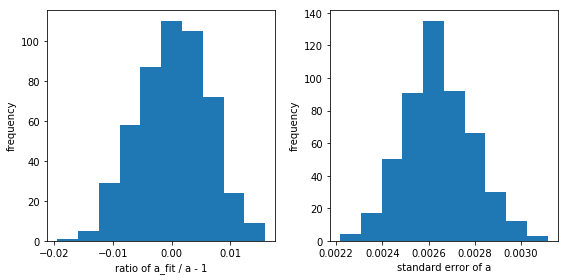

In [67]:
s = TestAmplitudeEstimator()
s.bootstrap(a=0.45)

## Bootstrap with amplitude = 0.495

C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (5.3096925865002405). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (4.383953384492771). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (4.031436965411673). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (6.745812352886309). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\

C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (7.192541454532317). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (8.042606637904996). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (6.679394509684083). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (8.887409607158384). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\s

C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (7.529719493239873). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.326985401820144). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (4.7792777014713215). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.840055644356756). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\

C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.635319922811627). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (5.413670798051943). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (6.78036459552286). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (2.369159461938799). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\si

C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.474207815219811). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (8.720954999203789). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (8.713716879189219). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.926150282701602). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\s

C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (6.8018406413357). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (7.97376047652014). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
C:\Anaconda3\envs\py36\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (8.348260795541906). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


mean = 0.00013002498353766677


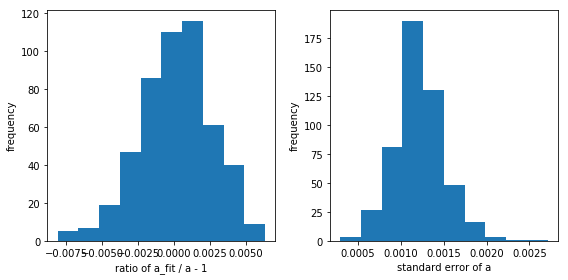

In [68]:
s = TestAmplitudeEstimator()
s.bootstrap(a=0.495)

# Test Amplitude estimator with custom prior

mean = 0.0005378918679596247


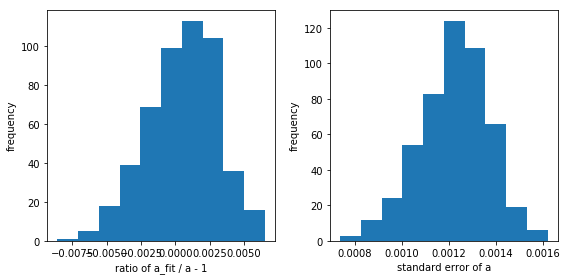

In [80]:
from qinfer import Distribution
from unittest import TestCase
import gvar

from qinfer import Distribution


class MyDistribution(Distribution):

    def n_rvs(self):
        return 2
    
    def sample(self, n=1):
        """
        """
        s = 0
        if s == 1:
            offset = 0.2 * np.random.rand(n) + 0.3

            a_min = 0
            a_max = np.minimum(0.5, offset)
            a = (a_max - a_min) * np.random.rand(n) + a_min
        
        else:
            a = 0.2 * np.random.rand(n) + 0.3

            o_min = np.maximum(0.3, a)
            o_max = 0.5
            offset = (o_max - o_min) * np.random.rand(n) + o_min



        return np.concatenate([a[:,np.newaxis], offset[:,np.newaxis], ], axis=1)






class TestAmplitudeEstimator2(TestCase):
    
    def test_qinfer_estimate(self, a, omega, phase, offset):
        """

        Returns:

        """

        true_omega = omega
        omega_min, omega_max = [0, 4 * np.pi]
        n_shots = 1000

        ts = np.linspace(0, 2, 20)

        signal = a * np.cos(true_omega * ts + phase) + offset

        assert np.all(signal <= 1) and np.all(signal >= 0)

        counts = np.random.binomial(n=n_shots, p=signal)

        data = np.column_stack([counts, ts, n_shots * np.ones_like(counts)])

        mean, cov, extra = self.run_estimate(data, true_omega,
                                             # freq_min=omega_min, freq_max=omega_max,
                                             return_all=True)

        return mean, cov

    @staticmethod
    def run_estimate(data, freq,
                     n_particles=10000, return_all=False):
        """this is a copy of qinfer.simple_

        Args:
            data:
            n_particles:
            return_all:

        Returns:

        """
        model = BinomialModel(AmplitudeEstimator(freq))
        
#         prior =  PostselectedDistribution(
#         UniformDistribution(
#             [
#                 [0.30, 0.5],
#                 [0.30, 0.5]
#              ]),
#            model,
#            maxiters=10000
#         )

        prior = MyDistribution()


        data = load_data_or_txt(data, [
            ('counts', 'uint'),
            ('t', float),
            ('n_shots', 'uint')
        ])

        outcomes, expparams = data_to_params(data,
            model.expparams_dtype,
            cols_expparams={
                't': (1, 't'),
                'n_meas': (2, 'n_shots')
            }
        )

        return do_update(
            model, n_particles, prior, outcomes, expparams,
            return_all
        )

    def bootstrap(self, a=0.45):
        """
        """
        omega = _twopi
        phi = 0
        offset = 0.50
        
        nbootstrap = 500
        amp = []
        for ii in range(nbootstrap):
            mean, cov = self.test_qinfer_estimate(a, omega, phi, offset)
            amp.append(gvar.gvar(mean[0], np.sqrt(np.diag(cov))[0]))
            
        a_weighted = np.mean(gvar.mean(amp))
        print('mean = {}'.format((a_weighted - a) / a))
            
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.hist((gvar.mean(amp) - a) / a)
        plt.xlabel('ratio of a_fit / a - 1')
        plt.ylabel('frequency')
        
        plt.subplot(1, 2, 2)
        plt.hist(gvar.sdev(amp))
        plt.xlabel('standard error of a')
        plt.ylabel('frequency')
        
        plt.tight_layout()
        
        plt.show()
        
        
        
s = TestAmplitudeEstimator2()
s.bootstrap(a=0.495)
        